# 이미지 파일 불러오기

In [2]:
import os

input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size= (160, 160)
# 클래스 개수 인접한 거, 속한 것, 속하지 않은 주변 픽셀
num_classes = 3
batch_size=32

input_img_path= sorted([os.path.join(input_dir, fname) 
                        for fname in os.listdir(input_dir)
                        if fname.endswith('.jpg')])
target_img_path = sorted([os.path.join(target_dir, fname)
                         for fname in os.listdir(target_dir)
                         if fname.endswith('.png') and not fname.startswith('.')])


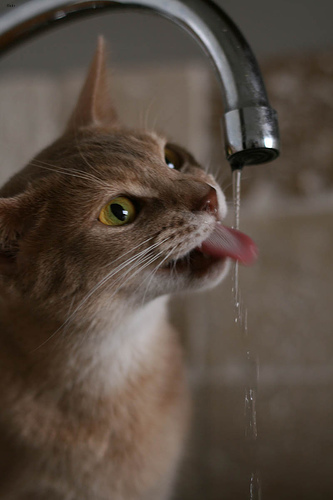

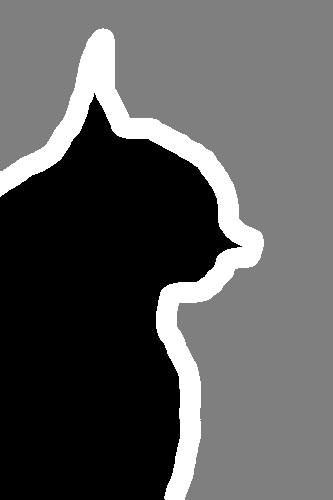

In [3]:
from IPython.display import Image, display
import PIL.ImageOps
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_path[21]))
img = PIL.ImageOps.autocontrast(load_img(target_img_path[21]))
display(img)

# 데이터 전처리

In [4]:
import numpy as np
from tensorflow import keras

class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_path, target_img_path):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
    #length
    def __len__(self):
        return len(self.target_img_path) // self.batch_size
    # idx (32개 배치 사이즈로 나눠서 처리)
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_path = self.input_img_path[i:i+self.batch_size]
        batch_target_img_path = self.target_img_path[i:i+self.batch_size]
        # 아래 사이즈에 이미지 단위로 부름
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_path):
            img = load_img(path, target_size= self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,)+self.img_size+(1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_path):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            y[j] = np.expand_dims(img, 2)
            # 레이블 1, 2, 3 -> 0, 1, 2
            y[j] -= 1

        return x, y

In [5]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_path)
random.Random(1337).shuffle(target_img_path)

train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

train_gen = OxfordPets(batch_size, img_size, train_input_img_path, train_target_img_path)
val_gen = OxfordPets(batch_size, img_size, val_input_img_path, val_target_img_path)

In [7]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs= keras.Input(shape=img_size + (3,))

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size, num_classes)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

In [10]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

epochs = 20
u_net = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/20
199/199 [==============================] - 53s 257ms/step - loss: 0.1512 - val_loss: 0.4318
Epoch 2/20
199/199 [==============================] - 64s 322ms/step - loss: 0.1403 - val_loss: 0.4331
Epoch 3/20
199/199 [==============================] - 64s 323ms/step - loss: 0.1374 - val_loss: 0.4421
Epoch 4/20
199/199 [==============================] - 64s 322ms/step - loss: 0.1296 - val_loss: 0.4461
Epoch 5/20
199/199 [==============================] - 64s 320ms/step - loss: 0.1269 - val_loss: 0.4892
Epoch 6/20
199/199 [==============================] - 64s 321ms/step - loss: 0.1246 - val_loss: 0.4925
Epoch 7/20
199/199 [==============================] - 64s 320ms/step - loss: 0.1197 - val_loss: 0.4904
Epoch 8/20
199/199 [==============================] - 64s 320ms/step - loss: 0.1148 - val_loss: 0.4831
Epoch 9/20
199/199 [==============================] - 64s 320ms/step - loss: 0.1114 - val_loss: 0.4708
Epoch 10/20
199/199 [==============================] - 64s 320ms/step - l

In [ ]:
import matplotlib.pyplot as plt

def showHistory(model):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(model.history['loss'], 'y', label='train_loss')
    loss_ax.plot(model.history['val_loss'], 'r', label='val_loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    # 범례 위치 설정
    loss_ax.legend(loc='upper left')

    acc_ax.plot(model.history['accuracy'], 'b', label='train_acc')
    acc_ax.plot(model.history['val_accuracy'], 'g', label='val_acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc = 'upper left')

    plt.show()

showHistory(u_net)    
